<a href="https://colab.research.google.com/github/Riashat/TabulaRL/blob/master/fixed_point_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Main papers:


1.   [Reverse accumulation and attractive fixed points](https://doi.org/10.1080/10556789408805572) by Bruce Christianson (1994)
2.   [Piggyback differentiation](https://doi.org/10.1007/978-3-642-55508-4_9) by Andreas Griewank and Christèle Faure (2003)


### What I found helpful:


*   (Suggested by Arushi) Schlenkrich S., Walther A., Gauger N.R., Heinrich R. (2008) [Differentiating Fixed Point Iterations with ADOL-C: Gradient Calculation for Fluid Dynamics](https://link.springer.com/chapter/10.1007/978-3-540-79409-7_36). In: Bock H.G., Kostina E., Phu H.X., Rannacher R. (eds) Modeling, Simulation and Optimization of Complex Processes. Springer, Berlin, Heidelberg (p 501-503)
*   Taftaf, A., Pascual, V., & Hascoët, L. (2014, July). [Adjoints of Fixed-Point Iterations.](https://hal.inria.fr/hal-01079185/document) 
* Pierre-Luc's [video](https://www.youtube.com/watch?v=_h5un62zybc&feature=youtu.be)
* [Autodiff Cookbook](https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/autodiff_cookbook.ipynb#scrollTo=1tFcRuEzkGRR)


<!-- Thanks to [Cem Anil](https://www.cs.toronto.edu/~anilcem/) for some of the starter code. -->

In [0]:
import jax
import jax.numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.animation import FuncAnimation
import itertools as it
rc('animation', html='html5')
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)

In [0]:
def F(x, theta):
    return theta * x * (1.0 - x)

def plot_f_for_various_thetas():
    thetas = np.arange(0.0, 4.0, 0.5)
    xs = np.linspace(0.0, 1.0, 100)
    cmap = plt.cm.plasma

    plt.figure(figsize=(10, 6))
    for theta in thetas:
        plt.plot(xs, F(xs, theta), label=theta, c=cmap(theta/4))
    plt.title(r"F(x, theta) vs. x")
    plt.xlabel('x')
    plt.ylabel("F(x, theta)")
    plt.legend(title="theta",bbox_to_anchor=(1, .8));

def animate_fixed_point_trajectory(theta, num_steps=8, num_trajs=3):
    cmap = plt.cm.plasma
    fig, ax = plt.subplots(figsize=(9, 9));
    %matplotlib inline
    plt.ion()

    # Produce fixed point iteration trajectory
    def iterate_f():
        # Pick random initialization x_0
        x_curr = npr.uniform(size=(1,))
        x_trajectory = [x_curr]
        # Apply Function Repeatedly
        for t in range(0,num_steps):
            x_next = F(x_curr,theta)
            x_trajectory.append(x_next)
            x_curr=x_next
        return x_trajectory
    
    # Produce multiple fixed point iteration trajectories for animation
    trajs_anim = it.chain([iterate_f() for i in range(0,num_trajs)])

    def init_plot():
        ax.set_title(npr.randint(10))
        ax.set_fisize=(19,9)
        ax.set_ylim(ymin=0)
        ax.set_xlim(xmin=0)
        xs = np.linspace(0.0, 1.0, 100)
        ax.plot(xs, F(xs, theta), label=r"{}".format(theta), c=cmap(theta/4))
        ax.plot(xs, xs,"g:");
        ax.text(0.5,.9,r"x_{t+1} = x_t",size=25, color='g');
        ax.set_xticks(np.arange(0.,1.2,0.2))
        ax.set_xticklabels(["0.","","","","","1."])
        ax.set_yticks(np.arange(0.,1.2,0.2))
        ax.set_yticklabels(["0.","","","","","1."])
        ax.set_xlabel(r"x_t",size=30)
        ax.set_ylabel(r"x_{t+1}",size=30)
        x_star = (theta - 1) / theta
        ax.scatter(x_star,x_star,s=100, c='y',zorder=10)
        ax.text(x_star-0.02,-0.05,r"x^*",color='y',size=30)
        ax.plot((x_star,x_star),(0,x_star),"y:")
        ax.set_title(r"Fixed point trajectories for theta = {}".format(theta))


    def animate(t):
        if t%num_steps==0:
            ax.clear()
            init_plot()
            global x_traj
            x_traj = next(trajs_anim)
            ax.text(x_traj[0]-0.02,-0.06,r"x_0",color='r',size=30);
            ax.scatter(x_traj[0],0.,s=100, c='r')
            ax.plot((x_traj[0],x_traj[0]),(0,x_traj[1]),"r:")
        x_curr = x_traj[t%num_steps]
        x_next = x_traj[t%num_steps+1]
        ax.plot((x_curr,x_next),(x_next,x_next),"r:")
        if t%num_steps>0:
            ax.plot((x_curr,x_curr),(x_curr,x_next),"r:")
        ax.scatter(x_curr,x_next,s=100, c='r',zorder=10)


    anim = FuncAnimation(
        fig, animate, interval=200, init_func=init_plot,frames=num_steps*num_trajs)
    return anim

In [0]:
def loss(x):
  return (x - .5)**2

# Introduction
Imagine we have a fixed-point equation:
$$x_* = F(x_*, \theta)$$

We are interested in some objective: $$\theta_* = \arg\min_{\theta}\mathcal{L}(x_*, \theta)$$

Example in RL: 
- $F$ the Bellman operator, $x_*$ value of policy $\theta$, $\mathcal{L}$ policy performance.

# What is a fixed point? 
Suppose we have a function $F(x,\theta): R^n \times R^q \rightarrow R^n$. 
* $x \in R^n$: "the state" of our system

Take the logistic function as an example: 
\begin{equation}
F(x, \theta) = \theta  x  (1 - x)
\end{equation}

In [0]:
def F(x, theta):
    return theta * x * (1.0 - x)

Repeatedly applying $F$ to its own input gives us a converging sequence $\{x_k\}$ for a given $\theta$.
\begin{equation}
x^* = \lim_{n\to\infty} F^{(n)}(x_0, \theta)
\end{equation}
At the fixed point, we have
$x_* = F(x_*, \theta)$.

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


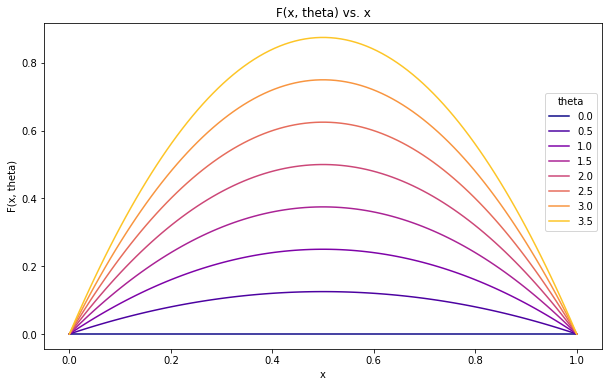

In [0]:
plot_f_for_various_thetas()

In [0]:
animate_fixed_point_trajectory(3.0,num_steps=6)

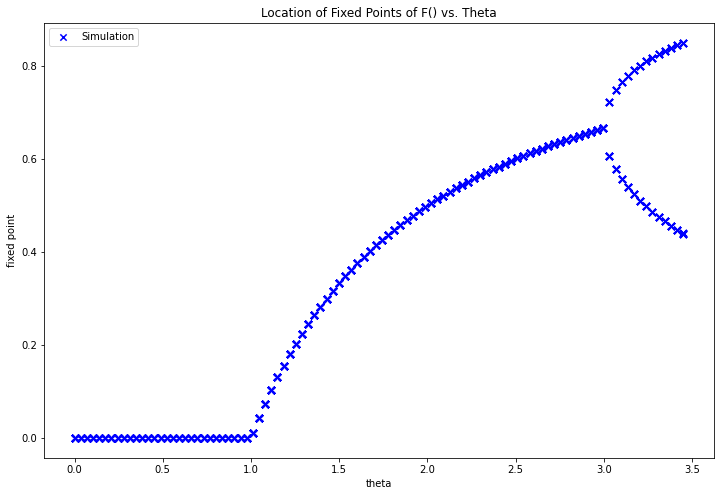

In [0]:
def plot_fixed_points_of_F():
    def F_repeated(x, theta, n=32):
        for i in range(n):
            x = F(x, theta)
        return x

    # def fixed_points_analytic(theta):
    #     return (theta - 1) / theta

    # Pick random initializations for simulation. 
    x_inits = npr.uniform(size=(100,))

    # Pick different thetas. 
    thetas = np.linspace(0.0, 1 + np.sqrt(6), 100)

    # Simulate and plot. 
    plt.figure(figsize=(12, 8))
    for theta in thetas:
        x_fixeds = F_repeated(x_inits, theta, n=10000)
        if theta != thetas[-1]:
            plt.scatter(theta*np.ones_like(x_fixeds), x_fixeds, marker="x", c="b", s=40)
        else:
            plt.scatter(theta*np.ones_like(x_fixeds), x_fixeds, marker="x", c="b", s=40, label="Simulation")
    # Also plot the analytical solution. 
    # x_fixeds_analytical = fixed_points_analytic(thetas)

    plt.title("Location of Fixed Points of F() vs. Theta")
    plt.xlabel("theta")
    plt.ylabel("fixed point")
    plt.legend()
  
plot_fixed_points_of_F()

<div style="font-size: 20px">

### <font color='crimson'> Aside: Directly finding the fixed points </font>

**Note:** We assume this is not possible to do at a reasonable cost but for this toy problem we will use it.

The fixed points of the system are the roots of the following function:

\begin{equation}
f(x^*, \theta) = F(x^*, \theta) - x = 0
\end{equation}

Can we apply potentially faster root finders on F?

Lets pick Netwon's Method. 

\begin{equation}
x_{t+1} = x_{t} - (\frac{\partial f}{\partial x}\Bigr\rvert_{x = x_t})^{-1}f(x_t)
\end{equation}

In [0]:
def f(x, theta):
    return F(x, theta) - x

J_f = jax.jacrev(f)

def newton_step(x_curr, theta):
    return x_curr - np.linalg.inv(J_f(x_curr, theta)) @ f(x_curr, theta)

def newton_solver(x_init, theta, num_iter=100):
    x = x_init
    for _ in range(num_iter):
        x = newton_step(x, theta)
    return x

# Objective that depends on the fixed point 

Usually we are interested in an objective that is a function of the state of the system:
\begin{align}
\theta_* = \arg\min_{\theta}\mathcal{L}(x_*, \theta) = \arg\min_{\theta}\mathcal{L}(F^{(\infty)}(x_0, \theta), \theta)
\end{align}

For simplicity, lets pick: 
\begin{equation}
\mathcal{L}(x_*) = (x_* - \frac{1}{2})^2
\end{equation}


Can we apply gradient descent? 

\begin{align}
\frac{\partial \mathcal{L}}{\partial \theta} = \frac{\partial \mathcal{L}(x_*, \theta)}{\partial \theta} + \frac{\partial \mathcal{L}(x_*, \theta)}{\partial x} \frac{\partial x_*}{\partial \theta}
\end{align}

**Challenge**: How can we compute $\frac{\partial x^*}{\partial \theta}$ ?

# <font color='crimson'> First Approach: Backprop through the solver</font>
Backprop through the fixed-point solver/iteration steps. 

**Problem:** Have to keep in memory all $\{x_k\}$ during forward sweeps



---


### <font color='Green'> Can we do better? </font>

(Based on Implicit Function Theorem.)

Lets say we know for $\theta$, the fixed point $x^*$. Then,

\begin{align}
\frac{d}{d\theta}\bigg(x_* &= F(x^*, \theta)\bigg) \\
\frac{dx_*}{d\theta}(\theta) &= \frac{dF}{dx}(x_*,\theta)\frac{dx_*}{d\theta} + \frac{dF}{d\theta}(x_*,\theta)\\
\frac{dx_*}{d\theta}(\theta) &= \bigg(I - \frac{dF}{dx}(x_*(\theta), \theta)\bigg)^{-1}\frac{dF}{d\theta}(x_*(\theta), \theta)
\end{align}

**Key Assumption:** $\left\Vert \frac{dF}{dx}(x_*,u)\right\Vert < 1$ to give us invertibility

Combined with the objective function, the full gradient is:
$$\frac{\partial \mathcal{L}}{\partial \theta} = \frac{\partial \mathcal{L}(x_*, \theta)}{\partial x}\bigg(I - \frac{dF}{dx}(x_*(\theta), \theta)\bigg)^{-1}\frac{dF}{d\theta}(x_*(\theta), \theta)$$


So knowing $x_*$ is enough to calculate the gradients!


---



In [0]:
# This code calculates the implicit gradient directly

def implicit_gradient(x, theta):
    return np.linalg.inv(np.eye(1) - jax.jacrev(F, 0)(x, theta))[0,0] * jax.jacrev(F, 1)(x, theta)[0,0]

# Set initial values. 
theta_init = np.array([1.1])
print("Initial theta: {}".format(theta_init))
lr = 1
theta = theta_init
iters = 61
implicit_losses = []
for i in range(iters):
    x_0 = jax.lax.stop_gradient(np.array([npr.uniform(0.5, 1.0)]))
    x_fixed = jax.lax.stop_gradient(newton_solver(x_0, theta))[0]
    curr_grad = jax.grad(loss)(x_fixed) * implicit_gradient(x_fixed, theta)
    theta = theta - lr*curr_grad
    implicit_losses.append(loss(x_fixed))
    # Print the loss. 
    if i % 5 == 0:
        print("\t Iter {}: , Loss: {}".format(i, loss(x_fixed)))
print("Optimal theta: {}".format(theta))
print("Expected answer: {} (using the analytic solution)".format(2.0))

Initial theta: [1.1]
	 Iter 0: , Loss: 0.16735537350177765
	 Iter 5: , Loss: 0.0008337136241607368
	 Iter 10: , Loss: 0.0001700775173958391
	 Iter 15: , Loss: 3.99344862671569e-05
	 Iter 20: , Loss: 9.945332749339286e-06
	 Iter 25: , Loss: 2.5459914922976168e-06
	 Iter 30: , Loss: 6.605933435821498e-07
	 Iter 35: , Loss: 1.7256927264952537e-07
	 Iter 40: , Loss: 4.522826202446595e-08
	 Iter 45: , Loss: 1.1884683459584267e-08
	 Iter 50: , Loss: 3.119172475862797e-09
	 Iter 55: , Loss: 8.236691328988854e-10
	 Iter 60: , Loss: 2.1674750882993976e-10
Optimal theta: [1.9999486]
Expected answer: 2.0 (using the analytic solution)


# <font color='crimson'> Second Approach: Two-phase </font>
Suppose we have some adjoint vector $\bar{x}^T \in \mathbb{R}^q$ from our computational graph, propagated backwards from our objective function.
The above becomes: 
$$\bar{\theta}_* = \bar{x}^T \frac{dx_*}{d\theta} = \underbrace{\bar{x}^T \bigg(I - \frac{dF}{dx}(x_*, \theta)\bigg)^{-1}}_\text{set to $\zeta_*^T$} \frac{dF}{d\theta}(x_*, \theta)$$
$\zeta^T$ can be thought of as the solution to another fixed-point equation, eliminating the need to invert the Jacobian:
$$ \zeta_{k+1}^T = \zeta_k^T \frac{dF(x_*, \theta)}{dx} + \bar{x}^T $$

The Two-Phase approach by Christianson (1994):
*   Step 1: Find fixed point $x_*$, by any solver, without accumulating gradients (except at the last step)
*   Step 2: In the backward sweep, solve for adjoint $\zeta_*^T$ and compute $\bar{\theta}_*$


<!-- Forward mode is similar but instead of solving for adjoint vector we solve for the "tangent" vector, and accumulate gradients from right to left -->

**Convergence guarantees**: Theorem 2.3 shows that (under mild assumptions) the uniform rate of convergence of $\zeta_*$ is the same as the asymptotic rate of convergence for $x_*$


In [0]:
#Christianson approach

def iterate_zeta(x_fixed, theta, num_steps=10):
    jac_L = jax.grad(loss)(x_fixed)
    # Pick random initialization x_0
    zeta_curr = npr.uniform(size=(1,))
    # Apply Function Repeatedly
    for t in range(0,num_steps):
        primals, F_vjp = jax.vjp(F, x_fixed, theta)
        zeta_next = F_vjp(zeta_curr)[0] + jac_L
        zeta_curr = zeta_next
    return zeta_curr


# Set initial values. 
theta_init = np.array([1.1])
print("Initial theta: {}".format(theta_init))
lr = 1
theta = theta_init
iters = 61
christ_losses = []
for i in range(iters):
    x_0 = jax.lax.stop_gradient(np.array([npr.uniform(0.5, 1.0)]))
    x_fixed = jax.lax.stop_gradient(newton_solver(x_0, theta))[0]
    zeta_fixed = iterate_zeta(x_fixed, theta[0])
    primals, F_vjp = jax.vjp(F, x_fixed, theta)
    curr_grad = F_vjp(zeta_fixed)[1]
    theta = theta - lr*curr_grad
    christ_losses.append(loss(x_fixed))
    # Print the loss. 
    if i % 5 == 0:
        print("\t Iter {}: , Loss: {}".format(i, loss(x_fixed)))
print("Optimal theta: {}".format(theta))
print("Expected answer: {} (using the analytic solution)".format(2.0))

Initial theta: [1.1]
	 Iter 0: , Loss: 0.16735534369945526
	 Iter 5: , Loss: 0.002342607593163848
	 Iter 10: , Loss: 0.0004008377145510167
	 Iter 15: , Loss: 8.848629659041762e-05
	 Iter 20: , Loss: 2.145014332199935e-05
	 Iter 25: , Loss: 5.421010882855626e-06
	 Iter 30: , Loss: 1.3976638228996308e-06
	 Iter 35: , Loss: 3.6399285363586387e-07
	 Iter 40: , Loss: 9.52358405470477e-08
	 Iter 45: , Loss: 2.4986604785226518e-08
	 Iter 50: , Loss: 6.5662684178846575e-09
	 Iter 55: , Loss: 1.7259402795843926e-09
	 Iter 60: , Loss: 4.5278980564944504e-10
Optimal theta: [1.9999254]
Expected answer: 2.0 (using the analytic solution)




---


What if we don't want to wait until $x_*$ has fully converged?

# <font color='crimson'> Third Approach: Piggyback Method </font> 
**Idea:** Compute derivatives together with the original iteration to find $x_*$.

$$ \zeta_{k+1}^T = \zeta_k^T \frac{dF(x_k, \theta)}{dx} + \frac{\partial \mathcal{L}(x_k, \theta)}{\partial x} $$

Specifically, find $x_k$ that satisfies some convergence criterion, then augment remaining iterations with derivative computations --> No need for a backward sweep.

### <font color='green'> Full Algorithm: </font> 
Let $f(x_*, \theta) := F(x_*, \theta) - x_* = 0$ and $w := f(x_*, \theta)$ = 0.

Suppose we use a fixed-point solver that computes 
$x_{k+1} = x_k - P_k f(x_k, \theta),$

where $P_k \in \mathbb{R}^{n \times n}$ approximates $\big(\frac{\partial f(x_k)}{\partial x}\big)^{-1}$ (i.e. ~ Newton's method).

do:

> $w_k = f(x_k, \theta)$

<!-- > $\bar{x}_k = \bar{w}_k \frac{dF(x_k, \theta)}{dx} + \bar{y} \frac{\partial \mathcal{L}(x_k, \theta)}{\partial x}$ -->

> $\bar{x}_k = \bar{w}_k \frac{\partial f(x_k, \theta)}{\partial x} + \frac{\partial \mathcal{L}(x_k, \theta)}{\partial x}$ *(see note in aside)*  

> $x_{k + 1} = x_k - P_k w_k$

> $\bar{w}_{k+1} = \bar{w}_k - \bar{x}_k P_k$

while $\left\Vert w_k \right\Vert, \left\Vert \bar{x}_k\right\Vert$ not small

**Results:** $x_*, \bar{w}_*$

**Finally:** $\bar{\theta}_* = \bar{w}_* \frac{\partial f (x_*, \theta)}{\partial \theta}+ \frac{\partial \mathcal{L}(x_*, \theta)}{\partial x}$

<font color='blue'> *Aside: (from adjoint sensitivity equation (9) in paper)* 

Since $$\bar{w_*} = -\frac{\partial \mathcal{L}(x_*, \theta)}{\partial x}\big(\frac{\partial f (x_*, \theta)}{\partial \theta}\big)^{-1},$$
we have 
$$\bar{x} = \bar{w_*}\frac{\partial f (x_*, \theta)}{\partial \theta} + \frac{\partial \mathcal{L}(x_*, \theta)}{\partial x} = 0$$ </font> 





**What do we gain:** Not having to wait until $x_*$ has converged allows us to optimize online, $x_k$ can be a good enough estimate. 

**Convergence main result:** $\bar{w}_k f(x_k, \theta) + \mathcal{L}(x_k, \theta)$ converges about twice as fast to $\mathcal{L}(x_*, \theta)$ as $\mathcal{L}(x_k, \theta)$ by itself.

In [0]:
#Piggyback
jac_f = jax.jacrev(f)
def piggyback_iterate(x_k, theta, threshold=1e-5):
    w_init = jax.lax.stop_gradient(np.array([npr.uniform(0.5, 1.0)]))
    bar_x_init = jax.lax.stop_gradient(np.array([npr.uniform(0, 0.5)]))
    bar_w_k_init = jax.lax.stop_gradient(np.array([npr.uniform(0.5, 1.0)]))
    
    w_k = w_init
    bar_x_k = bar_x_init
    bar_w_k = bar_w_k_init
  
    while (abs(w_k) > threshold) or (abs(bar_x_k) > threshold):
        jac_L = jax.jacrev(loss)(x_k)[0]
        w_k = f(x_k, theta)
        
        primals, f_vjp = jax.vjp(f, x_k, theta)
        bar_x_k = f_vjp(bar_w_k)[0] + jac_L
        
        P_k = np.linalg.inv(jac_f(x_k, theta))
        x_k_next = x_k - P_k @ w_k
        bar_w_k_next = bar_w_k - bar_x_k @ P_k

        x_k = x_k_next
        bar_w_k = bar_w_k_next
    return x_k, bar_w_k

# Set initial values. 
theta_init = np.array([1.1])
print("Initial theta: {}".format(theta_init))
lr = 1
theta = theta_init
iters = 61
threshold = 1e-5
pig_losses = []
for i in range(iters):
    x_0 = jax.lax.stop_gradient(np.array([npr.uniform(0.5, 1.0)]))
    x_k = jax.lax.stop_gradient(newton_solver(x_0, theta, num_iter=1))
    x_fixed, bar_w_fixed = piggyback_iterate(x_k, theta, threshold=threshold)
    primals, F_vjp = jax.vjp(F, x_fixed, theta)
    curr_grad = F_vjp(bar_w_fixed)[1] + jax.jacrev(loss)(x_fixed)[0]
    theta = theta - lr*curr_grad
    pig_losses.append(loss(x_fixed))
    # Print the loss. 
    if i % 5 == 0:
        print("\t Iter {}: , Loss: {}".format(i, loss(x_fixed)))
print("Optimal theta: {}".format(theta))
print("Expected answer: {} (using the analytic solution)".format(2.0))

Initial theta: [1.1]
	 Iter 0: , Loss: [0.16735534]
	 Iter 5: , Loss: [5.091636e-05]
	 Iter 10: , Loss: [3.206324e-09]
	 Iter 15: , Loss: [1.7408297e-13]
	 Iter 20: , Loss: [0.]
	 Iter 25: , Loss: [0.]
	 Iter 30: , Loss: [0.]
	 Iter 35: , Loss: [0.]
	 Iter 40: , Loss: [0.]
	 Iter 45: , Loss: [0.]
	 Iter 50: , Loss: [0.]
	 Iter 55: , Loss: [0.]
	 Iter 60: , Loss: [0.]
Optimal theta: [2.]
Expected answer: 2.0 (using the analytic solution)


# Comparison of Two-phase and Piggyback approaches


*   Both have convergence of adjoint sequences at similar rate to original fixed-point loop 
*   Both need a stopping criterion for adjoint fixed-point loop
* Piggyback:
  * Has additional assumptions on the iteration step
  * "Sufficient convergence" for original fixed-point loop may not be easily determined automatically.
  * Requires differentiating the objective repeatedly inside the adjoint iteration step, which may incur significat cost if the objective is some longer sequel of functions.



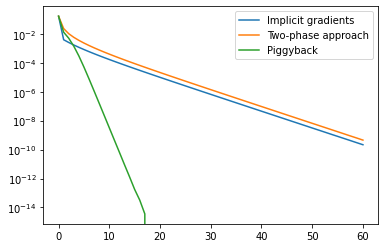

In [0]:
plt.plot(range(len(implicit_losses)), implicit_losses, label='Implicit gradients')
plt.plot(range(len(implicit_losses)), christ_losses, label='Two-phase approach')
plt.plot(range(len(implicit_losses)), pig_losses, label='Piggyback')
plt.yscale('log')
plt.legend()